<a href="https://colab.research.google.com/github/MehmethanOzansoy/deep_learning/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## iş Problemi (Busines Problem)

- **Date:** İlgili İşlem gününün tarihini temsil etmektedir
- **Open:** İlgili işlem gününü ait hisse başlangıç fiyatını temsil etmektedir


In [1]:

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


**Veriyi Anlamak(Data Understanding)**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import os 

os.environ['tf_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/TSLA.csv')

In [4]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [5]:
def check_df(df, head=5):
  print("################# SHAPE #####################")
  print(df.shape)
  print("################# Types #####################")
  print(df.dtypes)
  print("################# Head  #####################")
  print(df.head(head))
  print("################# Tail  #####################")
  print(df.tail(head))
  print("#################  NA   #####################")
  print(df.isnull().sum())
  print("################# Quantiles #################")
  print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [6]:
check_df(df)

################# SHAPE #####################
(2416, 7)
################# Types #####################
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
################# Head  #####################
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
################# Tail  #####################
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575.690002  589.7

In [7]:
df["Date"] = pd.to_datetime(df["Date"])

In [8]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [9]:
tesla_df = df[["Date","Close"]]

In [10]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [11]:
print("Minimum Tarih: ",tesla_df["Date"].min())
print("Maximum Tarih: ",tesla_df["Date"].max())

Minimum Tarih:  2010-06-29 00:00:00
Maximum Tarih:  2020-02-03 00:00:00


In [12]:
tesla_df.index = tesla_df["Date"]
tesla_df.head(3)

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999


In [13]:
tesla_df.drop("Date", axis=1,inplace=True)
tesla_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


In [14]:
result_df = tesla_df.copy()

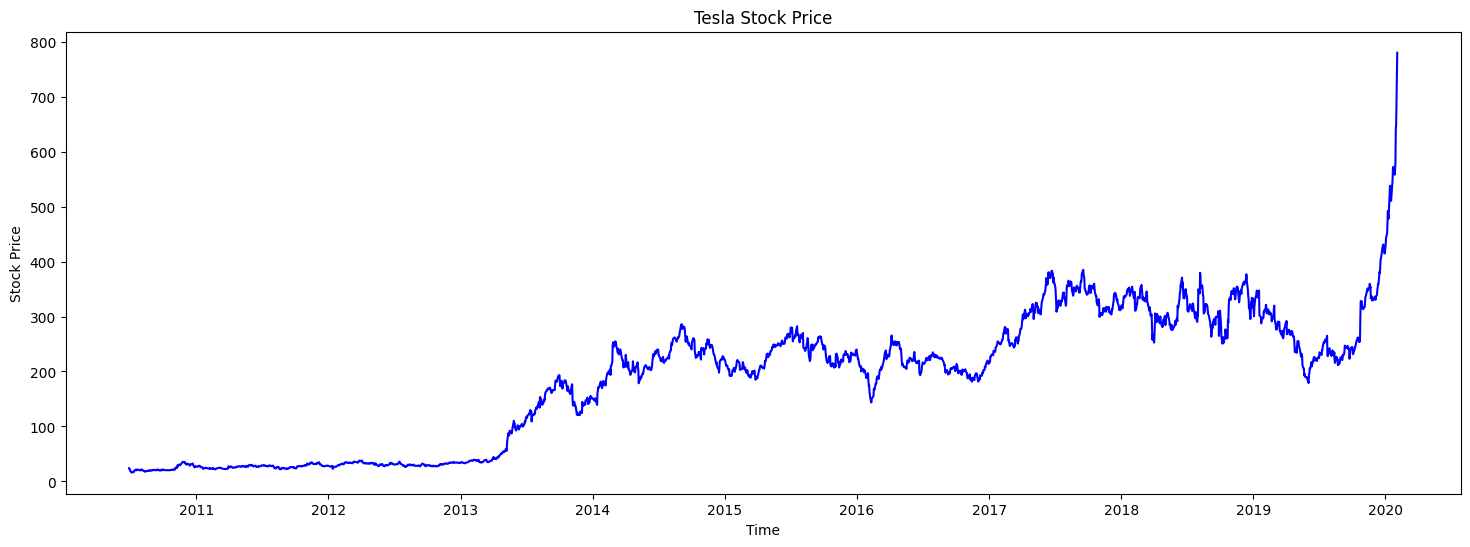

In [15]:
plt.figure(figsize=(18,6))
plt.plot(tesla_df['Close'], color= 'blue')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.title('Tesla Stock Price')
plt.show()

In [16]:
tesla_df = tesla_df.values

In [18]:
tesla_df[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [19]:
tesla_df = tesla_df.astype('float32')

In [20]:
def split_data(df, test_size):
  pos = int(round(len(df)* (1-test_size)))
  train = df[:pos]
  test = df[pos:]
  return train,test, pos

In [97]:
train, test, pos = split_data(tesla_df,0.20)

In [98]:
print(train.shape, test.shape)

(1933, 1) (483, 1)


In [100]:
scaler_train = MinMaxScaler(feature_range=(0,1))

In [101]:
train = scaler_train.fit_transform(train)

In [102]:
scaler_test = MinMaxScaler(feature_range=(0,1))

In [103]:
test = scaler_test.fit_transform(test)

In [104]:
print(train.shape, test.shape)

(1933, 1) (483, 1)


In [105]:
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [106]:
def create_features(data, lookback):
  X, Y = [], []

  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])

  return np.array(X), np.array(Y)

In [107]:
lookback = 20

In [108]:
X_train, y_train = create_features(train, lookback)

X_test, y_test = create_features(test, lookback)

In [109]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [110]:
X_train[0:5]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

In [111]:
y_train[0:5]

array([0.01332611, 0.01232395, 0.01121344, 0.01386782, 0.01665764],
      dtype=float32)

In [112]:
## 3 boyutlu yapcaz LSTM için

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


In [113]:
model = Sequential()

model.add(LSTM(units=50,
               activation='relu',
               input_shape=(X_train.shape[1], lookback)))

model.add(Dropout(0.2))
model.add(Dense(1))

In [114]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                14200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________


In [115]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [116]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1,mode='min'),
             ModelCheckpoint(filepath='mymodel.h5',moniter='val_loss', mode='min',save_best_only=True, save_weights_only=False, verbose=1)]

In [117]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test, y_test),
                    callbacks= callbacks,
                    shuffle=False)

Epoch 1/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0093
Epoch 1: val_loss improved from inf to 0.00410, saving model to mymodel.h5
96/96 [==============================] - 3s 9ms/step - loss: 0.0098 - val_loss: 0.0041
Epoch 2/100
95/96 [============================>.] - ETA: 0s - loss: 0.0070
Epoch 2: val_loss improved from 0.00410 to 0.00370, saving model to mymodel.h5
96/96 [==============================] - 1s 9ms/step - loss: 0.0071 - val_loss: 0.0037
Epoch 3/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0059
Epoch 3: val_loss improved from 0.00370 to 0.00363, saving model to mymodel.h5
96/96 [==============================] - 1s 9ms/step - loss: 0.0067 - val_loss: 0.0036
Epoch 4/100
89/96 [==========================>...] - ETA: 0s - loss: 0.0051
Epoch 4: val_loss improved from 0.00363 to 0.00341, saving model to mymodel.h5
96/96 [==============================] - 1s 7ms/step - loss: 0.0059 - val_loss: 0.0034
Epoch 5/100
95/96 [=================

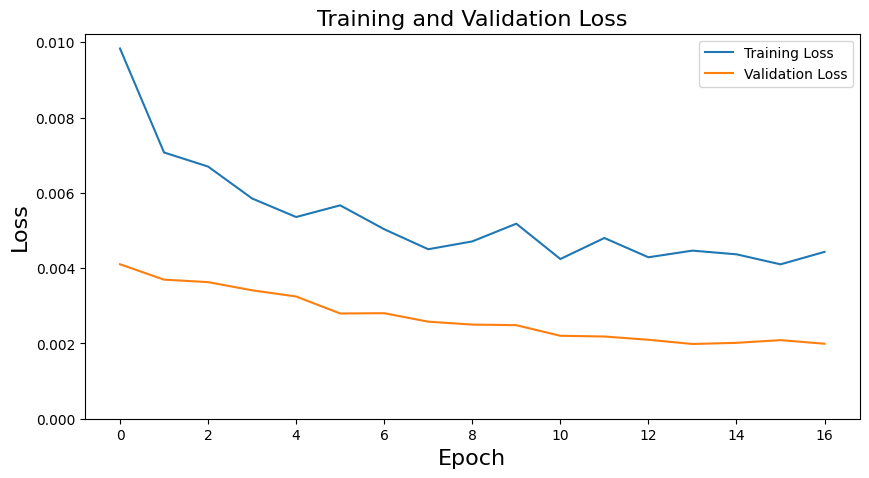

In [118]:
plt.figure(figsize=(22,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

In [119]:
loss = model.evaluate(X_test, y_test, batch_size=20)
print("\nTest loss: %.1f%%" % (100.0 * loss)) 

24/24 [==============================] - 0s 3ms/step - loss: 0.0020

Test loss: 0.2%


In [120]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

15/15 [==============================] - 0s 2ms/step


In [121]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [122]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [123]:
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))

In [124]:
test_rmse = np.sqrt(mean_squared_error(y_test,test_predict))

In [125]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 13.022913932800293
Test RMSE: 26.82680892944336


In [126]:
train_prediction_df = result_df[lookback:pos]
train_prediction_df["Predicted"] = train_predict
train_prediction_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,36.908489
2010-07-29,20.350000,36.908489
2010-07-30,19.940001,36.908489
2010-08-02,20.920000,36.908489
2010-08-03,21.950001,36.908489


In [127]:
test_pred_df = result_df[pos+lookback:]
test_pred_df["Predicted"] = test_predict
test_pred_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,307.183685
2018-04-04,286.940002,302.608795
2018-04-05,305.720001,303.975494
2018-04-06,299.299988,304.949646
2018-04-09,289.660004,306.447296


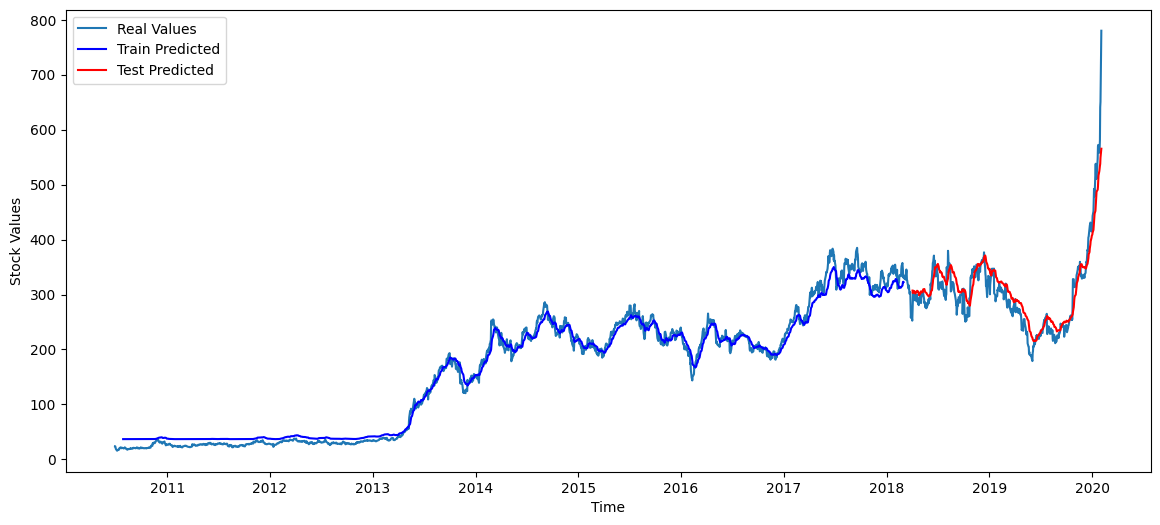

In [128]:
plt.figure(figsize=(14,6))
plt.plot(result_df, label= 'Real Values')
plt.plot(train_prediction_df["Predicted"], color='blue', label='Train Predicted')
plt.plot(test_pred_df["Predicted"], color="red", label="Test Predicted")
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.legend()
plt.show()